In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import mlflow
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [2]:
df = pd.read_csv("./data/nba_2022-23_all_stats_with_salary.csv")

In [3]:
df.head()

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [4]:
null_columns = df.columns[df.isnull().any()] 
df[null_columns][df.isnull().any(axis=1)]

,FG%,3P%,2P%,eFG%,FT%,TS%,3PAr,FTr
75,0.671,NaN,0.671,0.671,0.484,0.652,0.000,0.436
133,0.680,NaN,0.680,0.680,0.636,0.689,0.000,0.647
221,0.667,0.500,1.000,0.833,NaN,0.833,0.667,0.000
233,0.637,NaN,0.637,0.637,0.691,0.659,0.000,0.386
247,0.000,0.000,0.000,0.000,NaN,0.000,0.500,0.000
254,0.214,0.250,0.000,0.321,NaN,0.321,0.857,0.000
264,0.578,NaN,0.578,0.578,0.357,0.555,0.000,0.340
301,0.819,NaN,0.819,0.819,0.350,0.774,0.000,0.278
332,0.732,NaN,0.732,0.732,0.679,0.739,0.000,0.473
344,0.243,0.348,0.071,0.351,NaN,0.351,0.622,0.000


In [5]:
df[null_columns] = df[null_columns].fillna(0.000) # replace all NaN values with 0.000

In [6]:
df = df.drop(columns=['Unnamed: 0']) 

In [7]:
df.head()

,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,FGA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,20.2,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,9.9,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,13.6,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,22.2,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,18.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [8]:
df.columns

Index(['Player Name', 'Salary', 'Position', 'Age', 'Team', 'GP', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'Total Minutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%',
       'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP'],
      dtype='object')

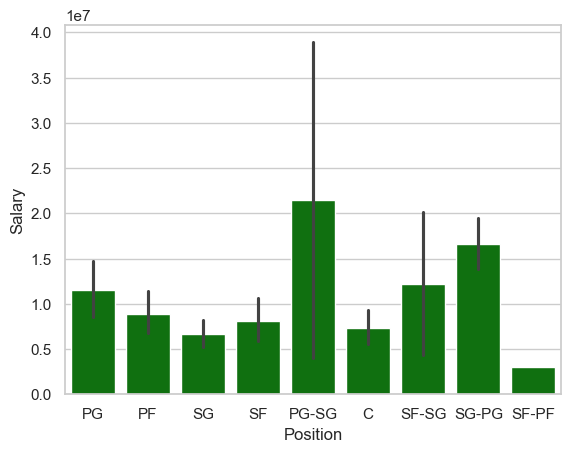

In [9]:
sns.set_theme(style="whitegrid")
sns.barplot(data=df,x='Position',y='Salary', estimator=np.mean, color="green")
plt.show()

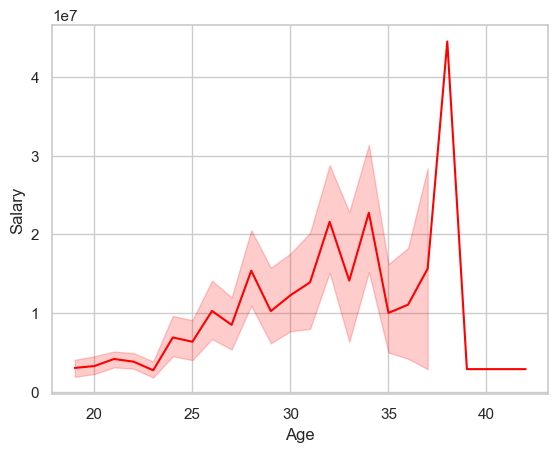

In [39]:
sns.set_theme(style="whitegrid")
sns.lineplot(data=df,x='Age',y='Salary', color="red")
plt.show()

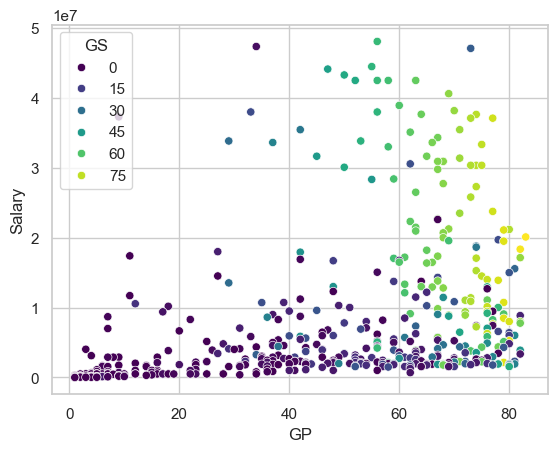

In [68]:
sns.scatterplot(data=df,x="GP",y="Salary",hue="GS", palette="viridis")
plt.show()

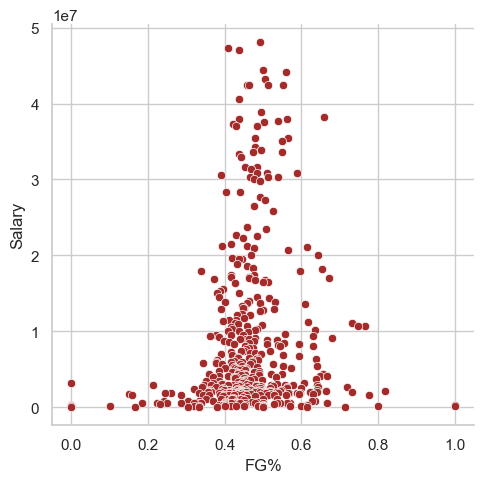

In [71]:
sns.relplot(data=df,x='FG%',y='Salary', color="brown")
plt.show()

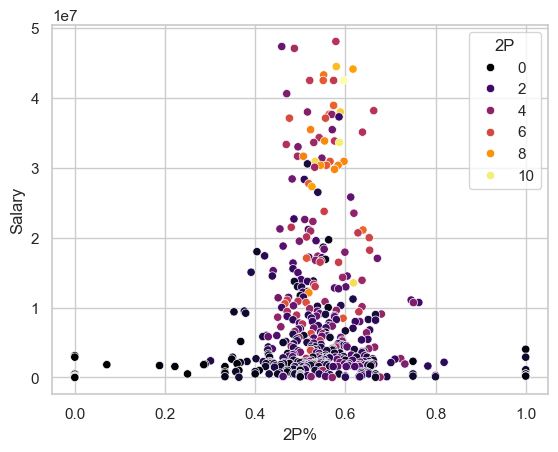

In [73]:
sns.scatterplot(data=df,x="2P%",y="Salary",hue="2P",color="gold", palette="inferno")
plt.show()

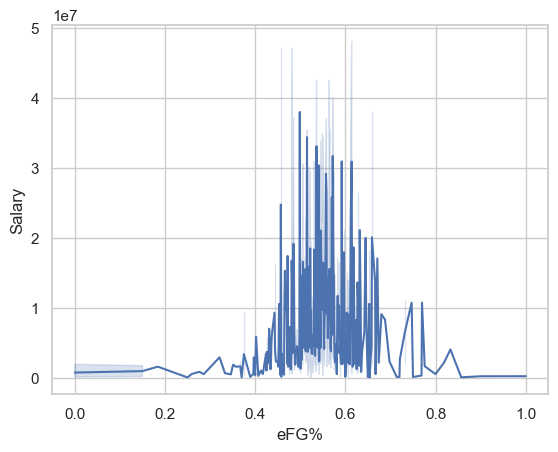

In [74]:
sns.lineplot(data=df,x="eFG%",y="Salary")
plt.show()

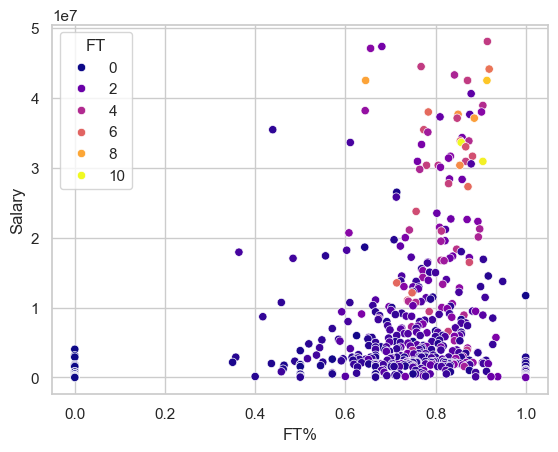

In [75]:
sns.scatterplot(data=df,x="FT%", y="Salary", hue="FT", palette="plasma")
plt.show()

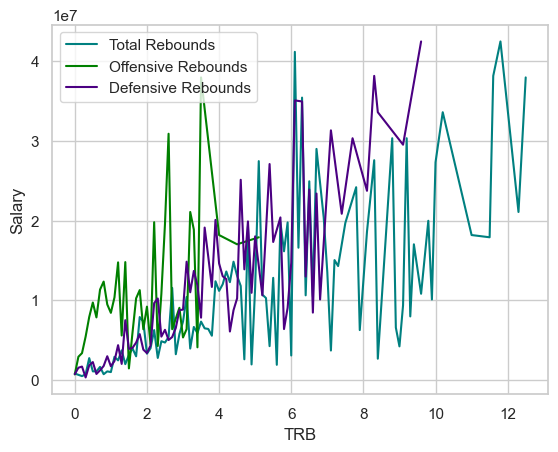

In [95]:
sns.set_theme(style="whitegrid")

sns.lineplot(data=df,x="TRB", y="Salary",errorbar=None, color="teal")
sns.lineplot(data=df,x="ORB", y="Salary", errorbar=None, color="green")
sns.lineplot(data=df,x="DRB", y="Salary", errorbar=None, color="indigo")

plt.legend(["Total Rebounds","Offensive Rebounds", "Defensive Rebounds"])


plt.show()

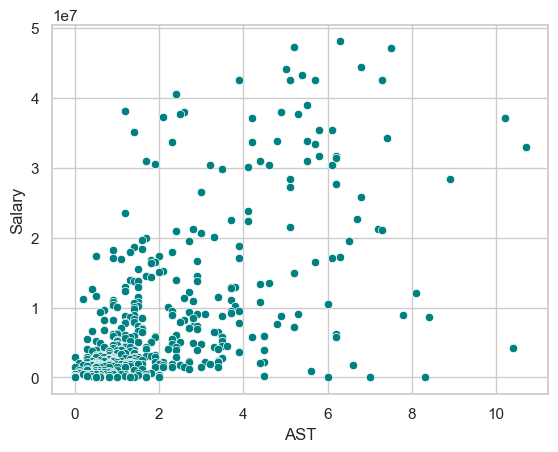

In [100]:
sns.scatterplot(data=df,x="AST", y="Salary", color="teal")
plt.show()

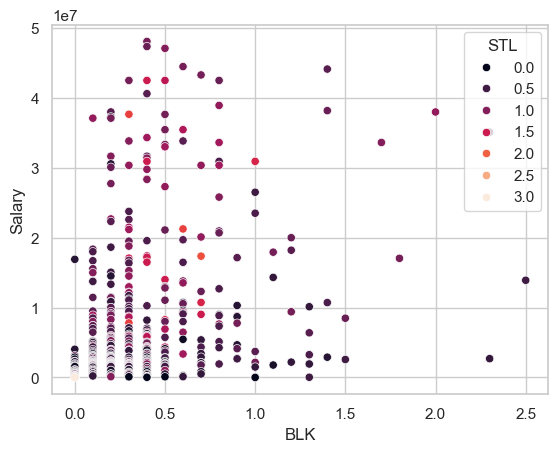

In [99]:
sns.scatterplot(data=df,x="BLK",y="Salary", hue="STL", palette="rocket")
plt.show()

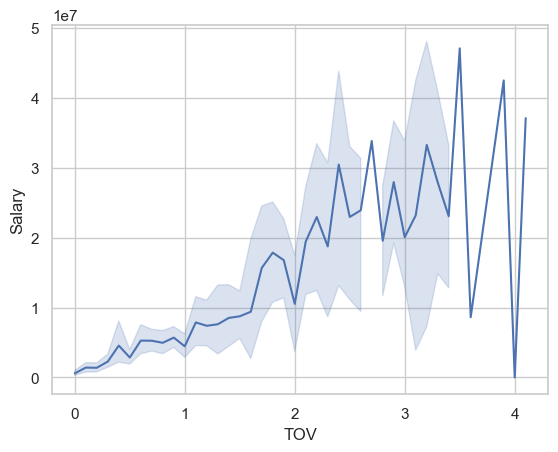

In [102]:
sns.lineplot(data=df,x="TOV",y="Salary")
plt.show()

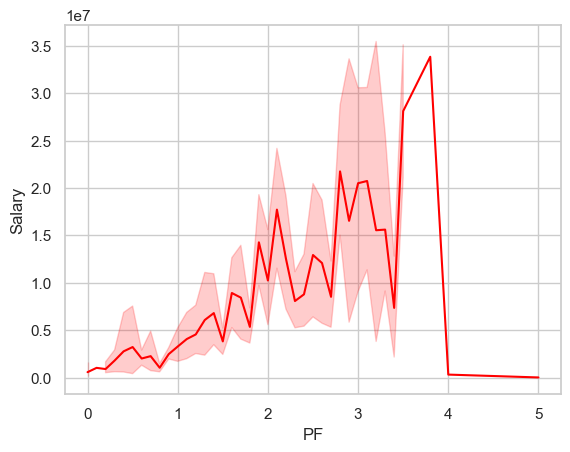

In [105]:
sns.lineplot(data=df,x="PF",y="Salary", color="red")
plt.show()

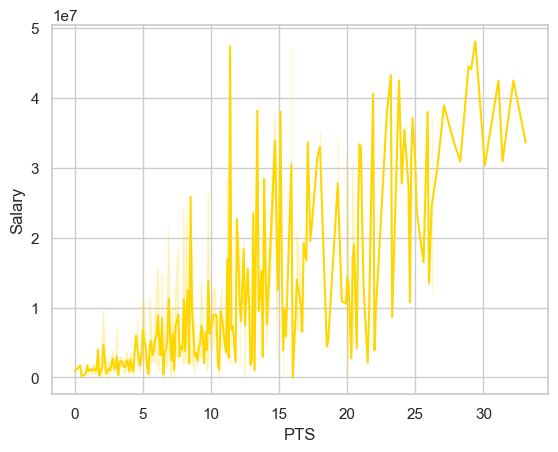

In [107]:
sns.lineplot(data=df,x="PTS",y="Salary", color="gold")
plt.show()

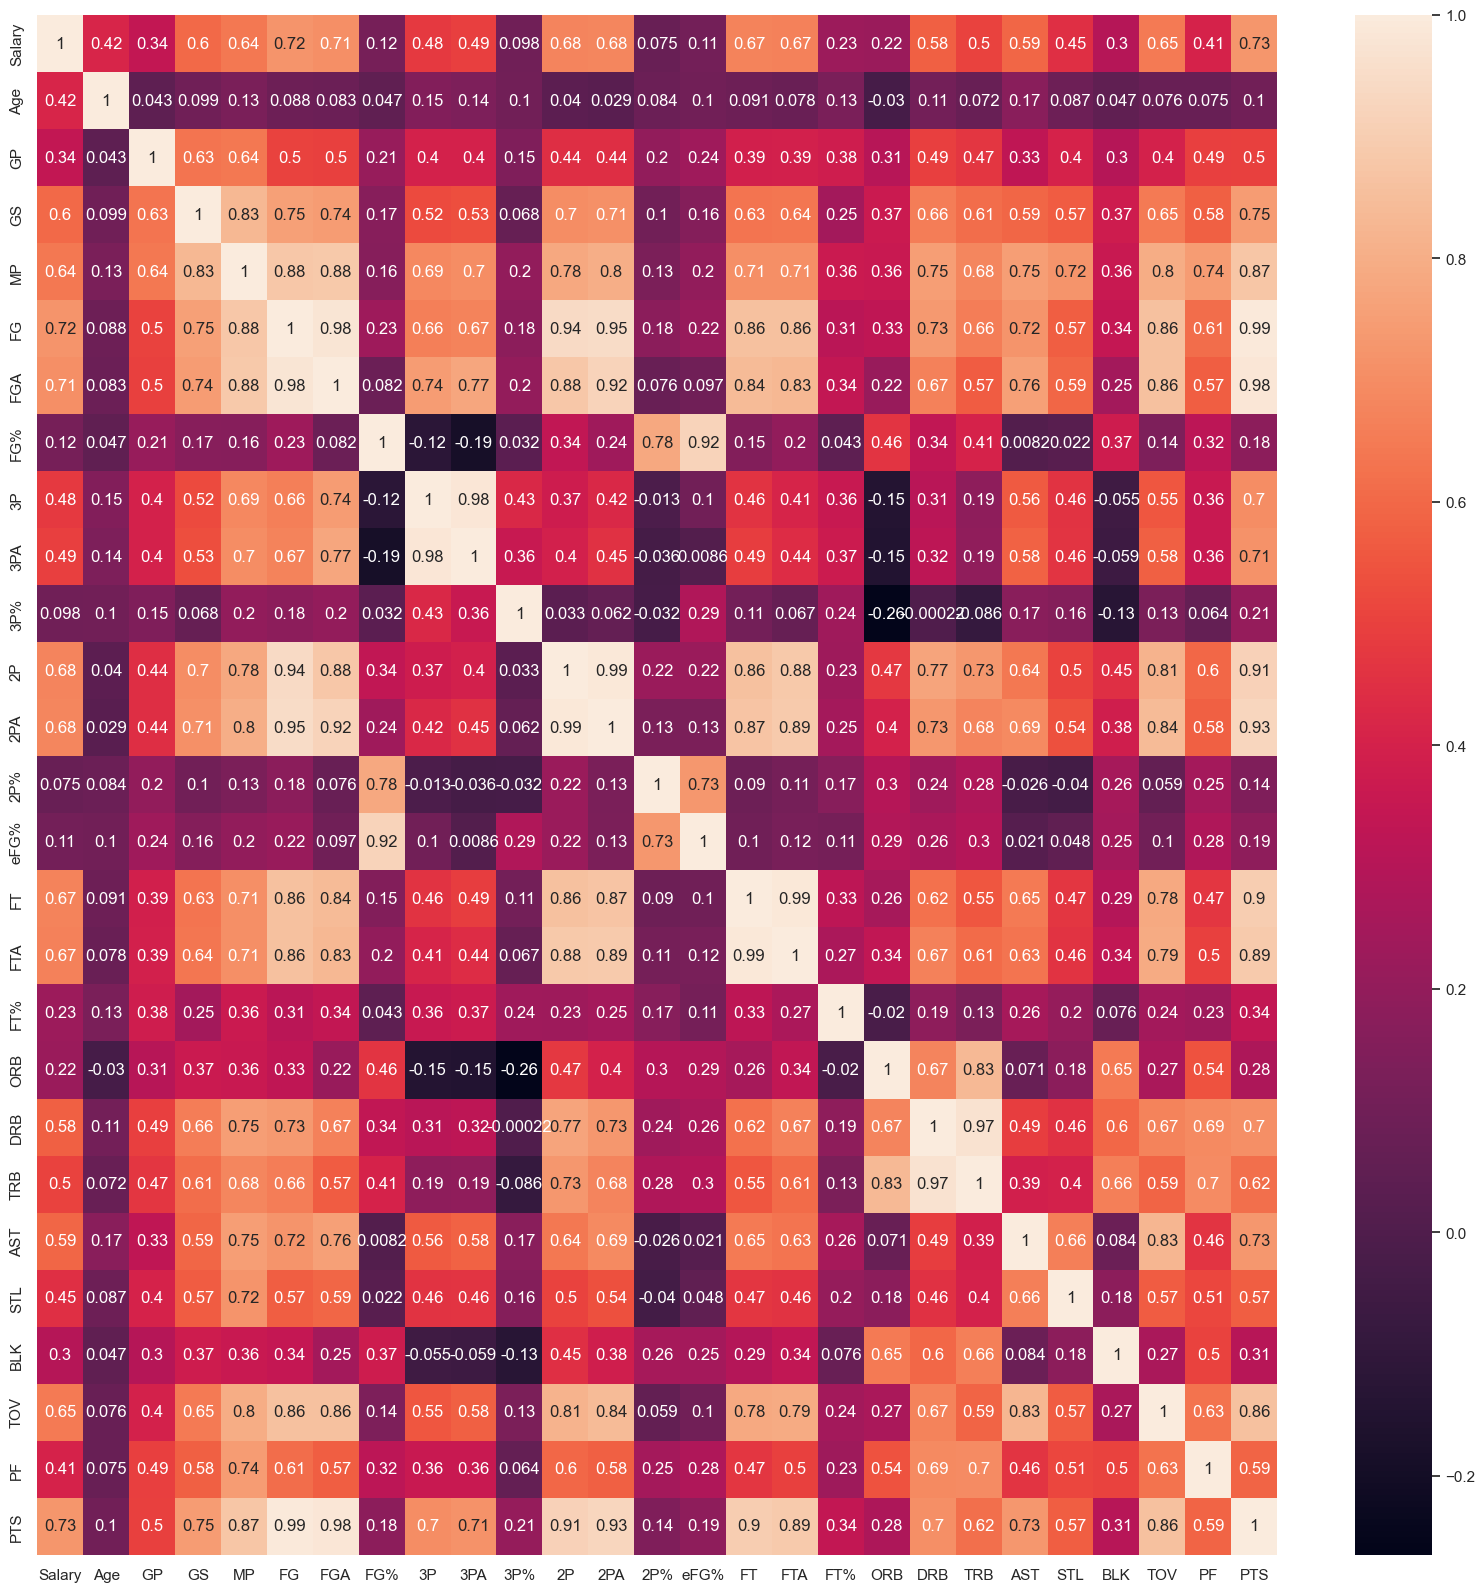

In [114]:
corr = df.select_dtypes(include=["int64","float64"]).corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr,annot=True)
plt.show()

In [9]:
dummies = pd.get_dummies(df["Position"],prefix="position").astype('int')
dataframe = df.drop(columns=["Player Name","Position","Team","Salary"])
dataframe = pd.concat([dataframe,dummies],axis=1)
target = df["Salary"]


In [10]:
dataframe.columns

Index(['Age', 'GP', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Total Minutes', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'position_C', 'position_PF', 'position_PG', 'position_PG-SG',
       'position_SF', 'position_SF-PF', 'position_SF-SG', 'position_SG',
       'position_SG-PG'],
      dtype='object')

In [11]:
X_train, X_test,y_train,y_test = train_test_split(dataframe,target, test_size=0.2, shuffle=True,random_state=42)

In [12]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [13]:
def model_metrics(model):   
    y_pred = model.predict(X_test_normalized)
    mae =  mean_absolute_error(y_test,y_pred)# mean absolute error
    rmse = mean_squared_error(y_test,y_pred, squared=False) # root mean squared error
    R2 = r2_score(y_test,y_pred)*100
    
    normalized_rmse = (rmse/(np.max(y_test)-np.min(y_test)))*100
    normalized_mae = (mae/(np.max(y_test)-np.min(y_test)))*100
    
    return {
        "mae": mae,
        "rmse": rmse,
        "r2_score": R2,
        "normalized_rmse": normalized_rmse,
        "normalized_mae": normalized_mae
    }
    

In [14]:
params = {
    "n_estimators": 1000,
    "max_features": 1.0,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "bootstrap": True
}

random_forest = RandomForestRegressor(**params)
random_forest.fit(X_train_normalized, y_train)
model_metrics(random_forest)

{'mae': 3775920.1540319147,
 'rmse': 5522946.8538166275,
 'r2_score': 77.02418015297897,
 'normalized_rmse': 11.497075032733314,
 'normalized_mae': 7.860303290536827}

In [15]:
params = {
    "n_estimators": 11000,
    "max_depth": 5,
    "min_samples_split": 2,
    "learning_rate": 0.05,
    "loss": "huber",
    "random_state":42
}
gb_regressor = GradientBoostingRegressor(**params)
gb_regressor.fit(X_train_normalized,y_train)
model_metrics(gb_regressor)

{'mae': 4148334.6345323687,
 'rmse': 5922344.1867379155,
 'r2_score': 73.58098775945699,
 'normalized_rmse': 12.328497319785809,
 'normalized_mae': 8.635555585899994}

In [16]:
params = {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'gamma': 5, 'colsample_bytree': 1.0}
xgboost_regressor = XGBRegressor(**params)
xgboost_regressor.fit(X_train_normalized, y_train)
model_metrics(xgboost_regressor)

{'mae': 4130641.5319148935,
 'rmse': 6356218.041386492,
 'r2_score': 69.56825456239561,
 'normalized_rmse': 13.231689110992123,
 'normalized_mae': 8.598723993321043}

In [24]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgboost_regressor, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

In [ ]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': [1.0, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the random forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Instantiate the randomized search model
rand_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist, cv=5, n_iter=100, n_jobs=-1)

# Fit the randomized search model
rand_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", rand_search.best_params_)

In [17]:
with open('models/nba_salaries_predictor_v1.bin', 'wb') as file:
    pickle.dump(random_forest, file)

In [22]:
mlflow.set_tracking_uri("http://ec2-54-227-30-175.compute-1.amazonaws.com:5000")
mlflow.set_experiment("my-nba-salary-experiment")


2024/01/31 16:15:46 INFO mlflow.tracking.fluent: Experiment with name 'my-nba-salary-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://nba-salary-predictor/3', creation_time=1706717748874, experiment_id='3', last_update_time=1706717748874, lifecycle_stage='active', name='my-nba-salary-experiment', tags={}>

In [23]:
with mlflow.start_run():
    params = {
    "n_estimators": 1000,
    "max_features": 1.0,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "bootstrap": True
    }

    mlflow.log_params(params)
    
    random_forest = RandomForestRegressor(**params)
    random_forest.fit(X_train_normalized, y_train)
    
    y_pred = random_forest.predict(X_test_normalized)
    
    mae =  mean_absolute_error(y_test,y_pred)# mean absolute error
    rmse = mean_squared_error(y_test,y_pred, squared=False) # root mean squared error
    R2 = r2_score(y_test,y_pred)*100
    
    mlflow.log_metric("rmse",rmse)
    mlflow.log_metric("mae",mae)

    normalized_rmse = (rmse/(np.max(y_test)-np.min(y_test)))*100
    normalized_mae = (mae/(np.max(y_test)-np.min(y_test)))*100
    
    mlflow.log_metric("normalized_rmse",normalized_rmse)
    mlflow.log_metric("normalized_mae", normalized_mae)
    mlflow.log_metric("r2_score",R2)
    
    mlflow.log_artifact(local_path="./data/nba_2022-23_all_stats_with_salary.csv",artifact_path="artifacts")
    mlflow.sklearn.log_model(random_forest, artifact_path="models")
    

2024/01/31 16:24:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\User\AppData\Local\Temp\tmpijp8471_\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.2', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback.
g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
g:\RGT-PROJECTS\MLOps-project\env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is rep